# Speech-based Emotion Recognition for Voice Comms.
## Script for batch data processing/augmentation

In [1]:
!pip install pysndfx
!pip install pydub
!pip install pytexit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pysndfx: filename=pysndfx-0.3.6-py3-none-any.whl size=6556 sha256=ab6551e881ebc12537ae0b7a7fc5291190a47d67e5337f224543b87ab9306939
  Stored in directory: /root/.cache/pip/wheels/2d/23/4c/8595647068440dec987dc615c4f5a7c64ba0e11364195cd568
Successfully built pysndfx
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pip install opendatasets --upgrade --quiet

# import opendatasets as od

# od.download('https://www.kaggle.com/datasets/ejlok1/cremad')
# od.download('https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio')
# od.download('https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess')
# od.download('https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee')

# !git clone https://github.com/marcogdepinto/emotion-classification-from-audio-files

In [2]:
import soundfile
import numpy as np
import math
import librosa
import glob
import os
import random
import matplotlib.pyplot as plt
from pysndfx import AudioEffectsChain
from pydub.silence import detect_nonsilent
from pydub import AudioSegment
from pytexit import py2tex # provides latex formula conversions
import torch

In [9]:
class AugmentData:
    def read_audio_file(self, file_path):
        data = librosa.core.load(file_path, sr=None)[0]
        return data
    
    # generating new .wav files from numpy array
    def write_audio_file(self, file, data, sample_rate=16000):
        soundfile.write(file, data, sample_rate)
    
    # example plots
    def plot_time_series(self, data):
        fig = plt.figure(figsize=(10, 4))
        plt.title('Raw wave')
        plt.ylabel('Amplitude')
        plt.style.use('ggplot')
        plt.plot(np.linspace(0, 1, len(data)), data)
        plt.show()
        
    # Silence removal, used for preprocessing each dataset
    def remove_sil(self, signal, basename):
        non_sil_times = detect_nonsilent(signal, min_silence_len=50, silence_thresh=signal.dBFS * 1.5)
        if len(non_sil_times) > 0:
            non_sil_times_concat = [non_sil_times[0]]
            if len(non_sil_times) > 1:
                for t in non_sil_times[1:]:
                    if t[0] - non_sil_times_concat[-1][-1] < 200:
                        non_sil_times_concat[-1][-1] = t[1]
                    else:
                        non_sil_times_concat.append(t)
            non_sil_times = [t for t in non_sil_times_concat if t[1] - t[0] > 350]
            signal[non_sil_times[0][0]: non_sil_times[-1][1]].export(os.path.join('data/TESS-nosil', basename), format="wav")
    
    # SNR augment(white noise generation) in dB
    # given a signal and desired SNR, 
    # this gives the required AWGN that should be added to the signal to achieve desired SNR
    def add_noise(self, signal, snr):
        #RMS value of signal
        RMS_s = math.sqrt(np.mean(signal**2))
        #RMS values of noise
        RMS_n = math.sqrt(RMS_s**2/(pow(10,snr/20)))
        #Additive white gausian noise. Therefore mean=0
        #Because sample length is large (typically > 40000)
        #we can use the population formula for standard daviation.
        #because mean=0 STD=RMS
        STD_n = RMS_n
        noise = np.random.normal(0, STD_n, signal.shape[0])
        return noise

    # reverb (decay time/wet level)
    def add_reverb(self,signal):
        # hardcoded args for batch processing
        fx = (
            AudioEffectsChain()
            .reverb(reverberance=20,
               hf_damping=75,
               room_scale=2,
               stereo_depth=20,
               pre_delay=0,
               wet_gain=0,
               wet_only=True)
        )
        
        y = fx(signal)
        return y
    
    # distortion/overdrive (clipping/nonlinear effects/mic emulation)
    def add_overdrive(self, signal):
        fx = (
            AudioEffectsChain()
            .overdrive(gain=30, colour=100)
        )
        
        y = fx(signal)
        return y

In [12]:
# Create a new instance of AugmentData class
ad = AugmentData()

# Silence removed paths
ravdess_path = "data/RAVDESS-noisil/*/*.wav"
c_path = "data/CREMA-D/AudioWAV/*.wav"
tess_path = "data/TESS/*/*.wav"
savee_path = "data/SAVEE/*/*.wav"

In [5]:
# import shutil
# from google.colab import drive
# drive.mount('/content/drive')
# shutil.copyfile('/content/drive/MyDrive/data.zip', 'data.zip')
# drive.flush_and_unmount()
# shutil.unpack_archive('data.zip', 'data')

Mounted at /content/drive


In [13]:
# White Noise
for file in glob.glob(ravdess_path):
    # get the base name of the audio file
    basename = os.path.basename(file)
    data = ad.read_audio_file(file)
    
    # Adding wn to soundfile
    data_noise = ad.add_noise(data, 20)
    datawn = data + data_noise
    
    # Write augmented soundfile wn
    ad.write_audio_file(os.path.join('data/augment-wn/RAVDESS-noisil', basename), datawn)

In [14]:
# White Noise
for file in glob.glob(c_path):
    # get the base name of the audio file
    basename = os.path.basename(file)
    data = ad.read_audio_file(file)
    
    # Adding wn to soundfile
    data_noise = ad.add_noise(data, 20)
    datawn = data + data_noise
    
    # Write augmented soundfile wn
    ad.write_audio_file(os.path.join('data/augment-wn/CREMA-D', basename), datawn)

In [15]:
# White Noise
for file in glob.glob(savee_path):
    # get the base name of the audio file
    basename = os.path.basename(file)
    data = ad.read_audio_file(file)
    
    # Adding wn to soundfile
    data_noise = ad.add_noise(data, 20)
    datawn = data + data_noise
    
    # Write augmented soundfile wn
    ad.write_audio_file(os.path.join('data/augment-wn/SAVEE', basename), datawn)

In [ ]:
# %%bash
# pip3 install sox
# sudo apt-get install sox libsox-fmt-all
# sudo apt-get install sox libsox-dev
# pip3 install pysox

In [20]:
# Reverb
for file in glob.glob(ravdess_path):
    # get the base name of the audio file
    basename = os.path.basename(file)
    data = ad.read_audio_file(file)

    # Adding reverb to soundfile
    data_reverb = ad.add_reverb(data.astype(np.float64))
    datarev = data + data_reverb

    # Write augmented soundfile reverb
    ad.write_audio_file(os.path.join('data/augment-reverb/RAVDESS-noisil', basename), datarev)

In [21]:
# Reverb
for file in glob.glob(c_path):
    # get the base name of the audio file
    basename = os.path.basename(file)
    data = ad.read_audio_file(file)

    # Adding reverb to soundfile
    data_reverb = ad.add_reverb(data.astype(np.float64))
    datarev = data + data_reverb

    # Write augmented soundfile reverb
    ad.write_audio_file(os.path.join('data/augment-reverb/CREMA-D', basename), datarev)

In [22]:
# Reverb
for file in glob.glob(savee_path):
    # get the base name of the audio file
    basename = os.path.basename(file)
    data = ad.read_audio_file(file)

    # Adding reverb to soundfile
    data_reverb = ad.add_reverb(data.astype(np.float64))
    datarev = data + data_reverb

    # Write augmented soundfile reverb
    ad.write_audio_file(os.path.join('data/augment-reverb/SAVEE', basename), datarev)

bbb

In [23]:
# Overdrive
for file in glob.glob(tess_path):
    # get the base name of the audio file
    basename = os.path.basename(file)
    data = ad.read_audio_file(file)

    # Simulated overdrive for soundfile
    data_od = ad.add_overdrive(data)

    # Write augmented soundfile reverb
    ad.write_audio_file(os.path.join('data/augment-overdrive/RAVDESS-noisil', basename), data_od)

In [24]:
# Overdrive
for file in glob.glob(c_path):
    # get the base name of the audio file
    basename = os.path.basename(file)
    data = ad.read_audio_file(file)

    # Simulated overdrive for soundfile
    data_od = ad.add_overdrive(data)

    # Write augmented soundfile reverb
    ad.write_audio_file(os.path.join('data/augment-overdrive/CREMA-D', basename), data_od)

In [25]:
# Overdrive
for file in glob.glob(savee_path):
    # get the base name of the audio file
    basename = os.path.basename(file)
    data = ad.read_audio_file(file)

    # Simulated overdrive for soundfile
    data_od = ad.add_overdrive(data)

    # Write augmented soundfile reverb
    ad.write_audio_file(os.path.join('data/augment-overdrive/SAVEE', basename), data_od)

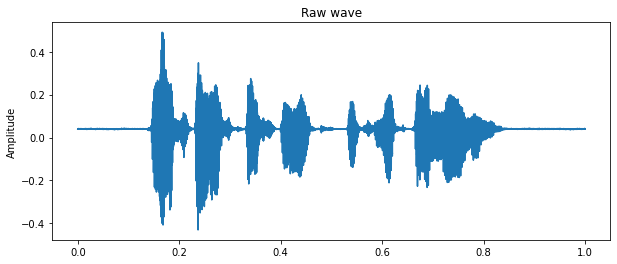

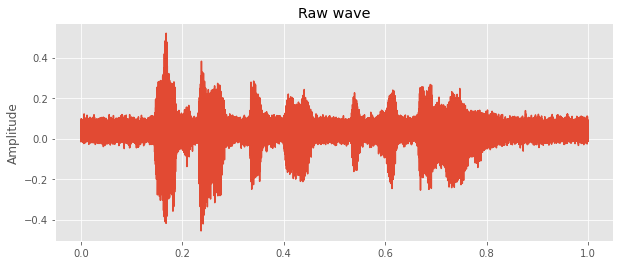

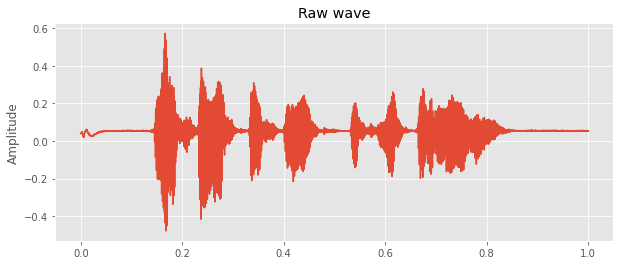

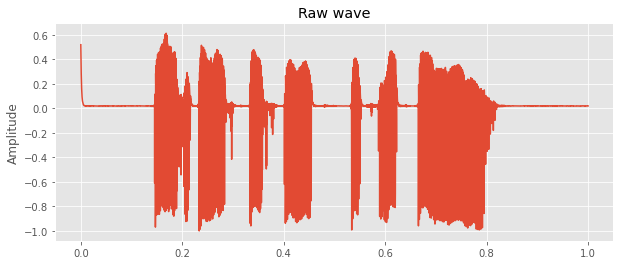

In [26]:
# plot last file in loop as example
ad.plot_time_series(data)
ad.plot_time_series(datawn)
ad.plot_time_series(datarev)
ad.plot_time_series(data_od)

In [28]:
# import shutil
# shutil.make_archive('data', 'zip', 'data')
# from google.colab import drive
drive.mount('/content/drive')
shutil.copyfile('data.zip', '/content/drive/MyDrive/data.zip')
drive.flush_and_unmount()

Mounted at /content/drive
